In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [12]:
# 1. Load and prepare data

# Đọc dữ liệu từ CSV
data = pd.read_csv('./stock_data/BTC_2010-2011.csv')

# Chuyển đổi cột 'Date' sang datetime và đặt làm index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# In ra các cột để kiểm tra
print("Các cột trong dữ liệu:", data.columns)

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Kiểm tra các cột trong dữ liệu
print("Các cột trong dữ liệu:", data.columns)

# Kiểm tra thống kê cơ bản của dữ liệu
print(data.describe())  # Xem thống kê dữ liệu
print("Số lượng giá trị NaN trong mỗi cột:")
print(data.isnull().sum())  # Kiểm tra giá trị NaN
print("Kiểm tra giá trị inf/-inf:")
print(data[data.isin([np.inf, -np.inf]).any(axis=1)])  # Kiểm tra giá trị inf

# Loại bỏ các hàng có giá trị NaN hoặc inf
data = data.dropna()  # Xóa hàng chứa NaN
data = data.replace([np.inf, -np.inf], np.nan).dropna()  # Loại bỏ inf/-inf

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Chuyển đổi scaled_data thành DataFrame để giữ tên cột và index
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Chuyển đổi scaled_data thành DataFrame để giữ tên cột và index
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Số bước thời gian
timesteps = 100

# Tạo X và y
X = []
y = []

# Xác định vị trí của cột 'Close'
close_index = data.columns.get_loc('Close')

for i in range(timesteps, len(scaled_data)):
    # Lấy dữ liệu của các bước thời gian trước đó cho tất cả các đặc trưng
    X.append(scaled_data.iloc[i - timesteps:i].values)
    # Lấy giá trị 'Close' tại thời điểm i làm mục tiêu dự đoán
    y.append(scaled_data.iloc[i, close_index])

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)  # (samples, timesteps, features)
print("Shape of y:", y.shape)  # (samples,)


Các cột trong dữ liệu: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Các cột trong dữ liệu: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
          Adj Close         Close          High           Low          Open  \
count  34105.000000  34105.000000  34105.000000  34105.000000  34105.000000   
mean   75734.798419  75734.798419  75734.798419  75734.798419  75734.798419   
std     9053.527931   9053.527931   9053.527931   9053.527931   9053.527931   
min    65198.042969  65198.042969  65198.042969  65198.042969  65198.042969   
25%    68153.375000  68153.375000  68153.375000  68153.375000  68153.375000   
50%    72066.203125  72066.203125  72066.203125  72066.203125  72066.203125   
75%    86629.593750  86629.593750  86629.593750  86629.593750  86629.593750   
max    93409.023438  93409.023438  93409.023438  93409.023438  93409.023438   

             Volume  
count  3.410500e+04  
mean   1.745148e+07  
std    1.568273e+0

#### Input (X): Sử dụng dữ liệu từ t-100 đến t để dự đoán giá trị Close tại bước t+1.
#### Target (y): Lấy giá trị Close tại thời điểm t+1 làm mục tiêu.     
#### LSTM sẽ sử dụng dữ liệu của 100 phút trước đó để dự đoán giá trị của phút tiếp theo.
#### Giá trị dự đoán là giá Close tại thời điểm t+1.

In [13]:
# Số bước thời gian
timesteps = 100

# Chuẩn hóa toàn bộ dữ liệu trước khi tạo X và y [0, 1]
scaler = MinMaxScaler() 
scaled_data = scaler.fit_transform(data)

# Tạo X và y
X = []
y = []
# for i in range(timesteps, len(data)):
#     X.append(data.iloc[i-timesteps:i, :-1].values)  # Các cột đầu vào
#     y.append(data.iloc[i, 1])  # Giá trị Close của bước tiếp theo

for i in range(timesteps, len(scaled_data)):
    # Lấy dữ liệu từ t-100 đến t
    X.append(scaled_data[i-timesteps:i, :-1])  # Các cột đầu vào
    # Giá trị Close tại thời điểm t+1 làm mục tiêu dự đoán
    y.append(scaled_data[i, 1])  # `1` là vị trí cột Close trong scaled_data

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)  # (samples, timesteps, features)
print("Shape of y:", y.shape)  # (samples,)


Shape of X: (34005, 100, 5)
Shape of y: (34005,)


In [14]:
# Chia dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (27204, 100, 5) Test size: (6801, 100, 5)


In [15]:
# Khởi tạo mô hình LSTM
model = Sequential()

# Thêm các tầng LSTM
# model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# return_sequences=True cho phép truyền toàn bộ chuỗi đặc trưng trung gian (hidden states) tới tầng LSTM tiếp theo.
model.add(LSTM(128, activation='relu', return_sequences=True, kernel_initializer='glorot_uniform', input_shape=(X_train.shape[1], X_train.shape[2])))

# Loại bỏ ngẫu nhiên 10% số nút trong quá trình huấn luyện để giảm overfitting.
model.add(Dropout(0.1))

# return_sequences=False nghĩa là tầng này chỉ giữ lại trạng thái cuối cùng của chuỗi (last hidden state).
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.1))

# Tầng đầu ra, dự đoán giá trị Close tại thời điểm t+1.
model.add(Dense(1))

# Compile mô hình
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

print(model.summary())

# Huấn luyện mô hình
# Epoch: Số lần toàn bộ dữ liệu huấn luyện được duyệt qua (50 lần trong mô hình này).
# Batch size: Số mẫu trong một lô dữ liệu được đưa vào mô hình cùng lúc (32 mẫu).
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 128)       │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 53s 77ms/step - loss: 0.0446 - mae: 0.0446 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 2/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 52s 77ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0074 - val_mae: 0.0074
Epoch 3/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 51s 75ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0042 - val_mae: 0.0042
Epoch 4/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 51s 75ms/step - loss: 0.0179 - mae: 0.0179 - val_loss: 0.0040 - val_mae: 0.0040
Epoch 5/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 51s 75ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0061 - val_mae: 0.0061
Epoch 6/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0057 - val_mae: 0.0057
Epoch 7/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 50s 73ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0097 - val_mae: 0.0097
Epoch 8/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0105 - val_mae: 0.0105
Epoch 9/50
681/681 ━━━━━━━━━━━━━━━━

In [16]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Hiển thị kích thước đầu ra
print("Shape of predictions:", y_pred.shape)


213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
Shape of predictions: (6801, 1)


In [17]:
# Chuyển đổi giá trị dự đoán và thực tế về thang đo gốc
y_pred_original = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], data.shape[1] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))), axis=1))[:, 0]

In [18]:
# mse = mean_squared_error(y_test_original, y_pred_original)
# mae = mean_absolute_error(y_test_original, y_pred_original)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")


MSE: 3.211922868565162e-05
MAE: 0.0046515530948092266


                     Thời gian  Thực tế (Actual)  Dự đoán (Predicted)  Hiệu (Actual - Predicted)
0    2024-11-13 11:50:00+00:00          68261.34             68489.43                    -228.09
1    2024-11-13 11:51:00+00:00          72501.02             72565.77                     -64.75
2    2024-11-13 11:53:00+00:00          67413.67             67561.99                    -148.32
3    2024-11-13 11:54:00+00:00          73598.34             73364.55                     233.80
4    2024-11-13 11:56:00+00:00          70705.36             70756.63                     -51.27
5    2024-11-13 11:57:00+00:00          67846.57             67944.55                     -97.98
6    2024-11-13 11:59:00+00:00          65978.63             66264.91                    -286.27
7    2024-11-13 12:00:00+00:00          67703.96             67827.09                    -123.13
8    2024-11-13 12:02:00+00:00          91789.95             91776.81                      13.14
9    2024-11-13 12:03:00+00:00

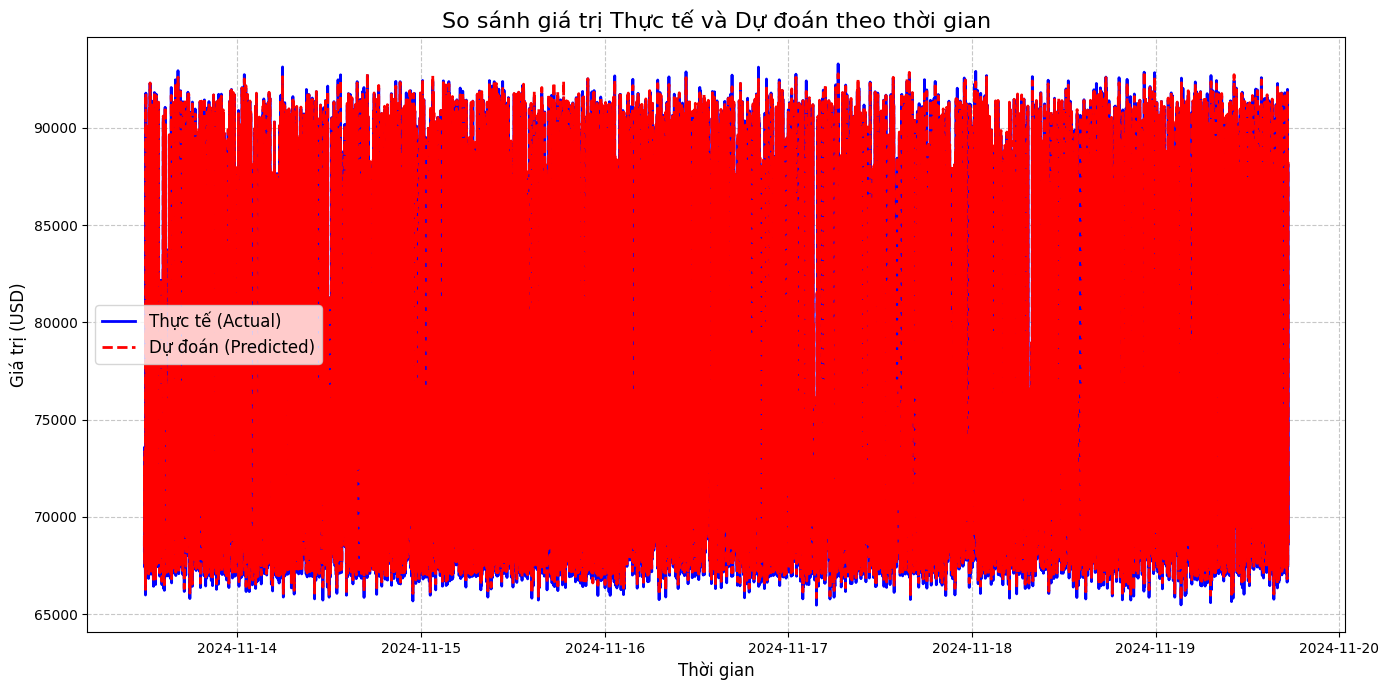

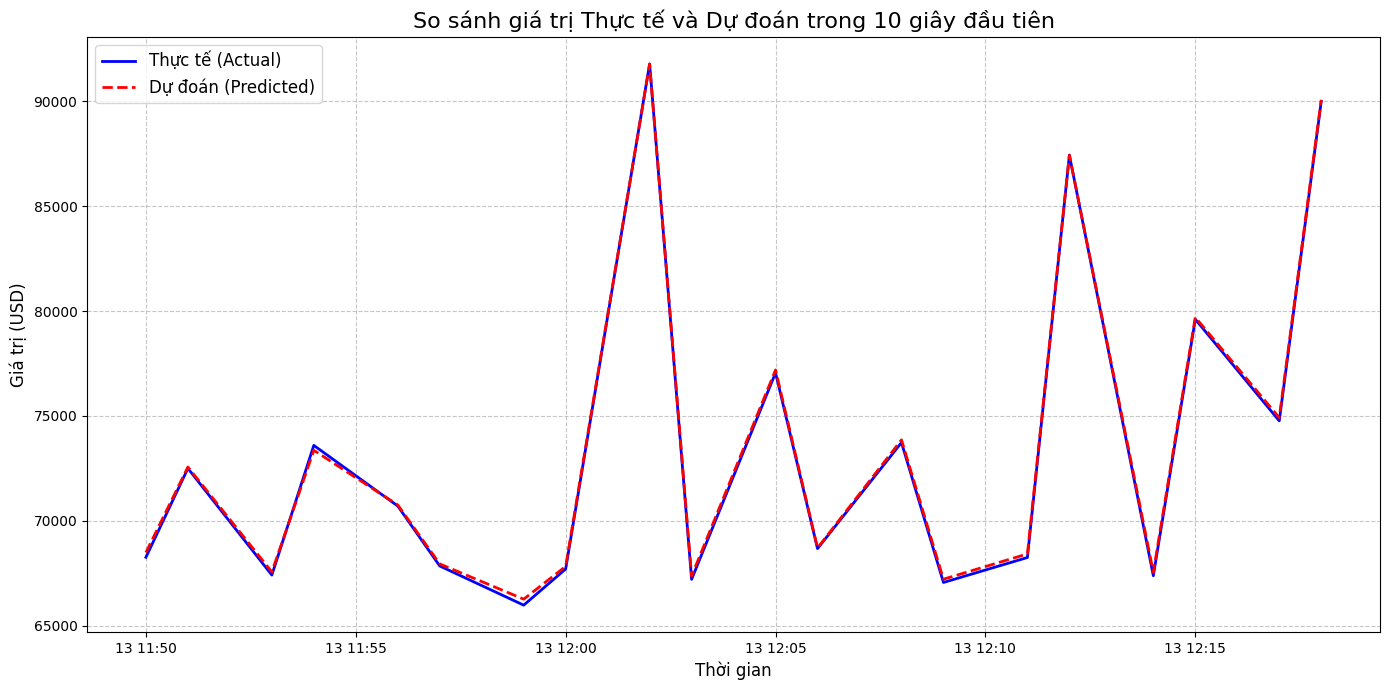

In [29]:
time_index_test = data.index[-len(y_test_original):]  # Lấy thời gian tương ứng với tập test

# Tạo DataFrame chứa thông tin chi tiết từng phút
results_df = pd.DataFrame({
    "Thời gian": time_index_test,  # Cột thời gian
    "Thực tế (Actual)": y_test_original,  # Giá trị thực tế
    "Dự đoán (Predicted)": y_pred_original,  # Giá trị dự đoán
    "Hiệu (Actual - Predicted)": y_test_original.flatten() - y_pred_original.flatten()  # Hiệu giữa thực tế và dự đoán
})

# In kết quả chi tiết
pd.set_option('display.max_columns', None)  # Hiển thị đầy đủ các cột
pd.set_option('display.width', 200)  # Hiển thị ngang dòng
print(results_df)

plt.figure(figsize=(14, 7))
plt.plot(results_df["Thời gian"], results_df["Thực tế (Actual)"], label="Thực tế (Actual)", color='blue', linestyle='-', linewidth=2)
plt.plot(results_df["Thời gian"], results_df["Dự đoán (Predicted)"], label="Dự đoán (Predicted)", color='red', linestyle='--', linewidth=2)
plt.title("So sánh giá trị Thực tế và Dự đoán theo thời gian", fontsize=16)
plt.xlabel("Thời gian", fontsize=12)
plt.ylabel("Giá trị (USD)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Chỉ lấy 10 giây đầu tiên từ DataFrame
results_df_10s = results_df.head(20)

# Vẽ biểu đồ với 10 giây đầu tiên
plt.figure(figsize=(14, 7))
plt.plot(results_df_10s["Thời gian"], results_df_10s["Thực tế (Actual)"], label="Thực tế (Actual)", color='blue', linestyle='-', linewidth=2)
plt.plot(results_df_10s["Thời gian"], results_df_10s["Dự đoán (Predicted)"], label="Dự đoán (Predicted)", color='red', linestyle='--', linewidth=2)
plt.title("So sánh giá trị Thực tế và Dự đoán trong 10 giây đầu tiên", fontsize=16)
plt.xlabel("Thời gian", fontsize=12)
plt.ylabel("Giá trị (USD)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()